In [1]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
def take_samples(dataset, n=16):
    res = []
    rand_indices = np.random.choice(len(dataset), n, replace=False)

    for i in rand_indices:
        res.append(dataset[i])

    return res


def show_sample(sample):
    # import matplotlib.pyplot as plt
    # from einops import rearrange

    img, label = sample
    img = rearrange(img, "c h w -> h w c")

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label {label}")


def show_samples(samples, figsize=(10, 10)):
    # import numpy as np
    # import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)

    nrows = ncols = int(np.ceil(len(samples) ** 0.5))

    for subplot_idx, sample in enumerate(samples):
        plt.subplot(nrows, ncols, subplot_idx + 1)
        show_sample(sample)

    plt.tight_layout()


def plot_line(y_mean, y_std, label=None, x=None):
    # import numpy as np
    # import matplotlib.pyplot as plt

    if x is None:
        x = np.arange(len(y_mean), dtype=int) + 1
        plt.xticks(x)

    assert len(x) == len(y_mean) == len(y_std)
    x, y_mean, y_std = np.array(x), np.array(y_mean), np.array(y_std)

    plt.plot(x, y_mean, label=label)

    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2)


def plot_lines(results, xlabel="Epoch", ylabel="Loss"):
    # import matplotlib.pyplot as plt

    max_n_epochs = float("-inf")

    for res in results:
        y_mean = res["mean"]
        y_std = res["std"]
        label = res["label"]

        max_n_epochs = max(max_n_epochs, len(y_mean))

        plot_line(y_mean, y_std, label)

    x = np.arange(max_n_epochs, dtype=int) + 1
    plt.xticks(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

In [3]:
import os
from datetime import datetime
import numpy as np

import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from einops.layers.torch import Rearrange
from einops import rearrange, repeat, einsum

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


class LossCalculator:
    def __init__(self, model, loss_fn, device):
        model.to(device)

        self.model = model
        self.loss_fn = loss_fn
        self.device = device

    def __call__(self, X, y):
        X, y = X.to(self.device), y.to(self.device)
        y_pred = self.model(X)
        loss = self.loss_fn(y_pred, y)
        return loss


def one_epoch_train(train_loader, loss_calculator, optimizer):
    loss_calculator.model.train()

    for X, y in train_loader:
        loss = loss_calculator(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def one_epoch_test(test_loader, loss_calculator):
    # import numpy as np
    # import torch

    losses = []
    loss_calculator.model.eval()

    with torch.inference_mode():
        for X, y in test_loader:
            loss = loss_calculator(X, y)
            losses.append(loss.item())

    return np.mean(losses), np.std(losses)


def train(
    model,
    loss_fn,
    n_epochs,
    train_loader,
    test_loader,
    optimizer_cls=None,
    device=None,
    result={},
):
    # import torch
    # from datetime import datetime

    result["mean"] = []
    result["std"] = []

    if optimizer_cls is None:
        optimizer_cls = torch.optim.AdamW
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    loss_calculator = LossCalculator(model, loss_fn, device)
    optimizer = optimizer_cls(params=model.parameters())
    start = datetime.now()

    for i in range(n_epochs):
        one_epoch_train(train_loader, loss_calculator, optimizer)

        mean, std = one_epoch_test(test_loader, loss_calculator)
        result["mean"].append(mean)
        result["std"].append(std)

        print(f"""Epoch {i+1}, Loss: {result["mean"][-1]} +- {result["std"][-1]}""")

    avg_time_per_epoch = (datetime.now() - start) / n_epochs
    print(f"Average time per epoch: {avg_time_per_epoch}")
    return result


def make_loader(dataset, batch_size, split_size=[0.75, 0.25], n_workers=None):
    # import os
    # from torch.utils.data import random_split, DataLoader

    if n_workers is None:
        n_workers = os.cpu_count()

    train_set, test_set = random_split(dataset, split_size)
    train_loader = DataLoader(
        train_set, batch_size, shuffle=True, num_workers=n_workers
    )
    test_loader = DataLoader(test_set, 1, shuffle=False, num_workers=n_workers)

    return train_loader, test_loader


class MLP(nn.Module):
    # from torch import nn

    def __init__(
        self,
        in_d,
        out_d,
        hid_d_ratio=2,
        n_hid_layer=2,
        drop_p=0.1,
        activation_init=nn.GELU,
        pre_modules=[],
        post_modules=[],
    ):
        super().__init__()

        assert n_hid_layer >= 1

        hid_d = int(hid_d_ratio * in_d)
        dropout = nn.Dropout(drop_p)
        act_fn = activation_init()
        modules = []

        if len(pre_modules) > 0:
            modules += pre_modules
        modules.extend(
            [
                nn.Linear(in_d, hid_d),
                act_fn,
            ]
        )

        for i in range(n_hid_layer - 1):
            modules.extend(
                [
                    dropout,
                    nn.Linear(hid_d, hid_d),
                    act_fn,
                ]
            )

        modules.extend(
            [
                dropout,
                nn.Linear(hid_d, out_d),
            ]
        )
        if len(post_modules) > 0:
            modules += post_modules

        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class ViTEmbedding(nn.Module):
    # from einops.layers.torch import Rearrange
    # from einops import rearrange, repeat
    # import torch
    # from torch import nn

    def __init__(self, img_res, patch_res, in_chans, embed_dim):
        super().__init__()

        self.in_chans = in_chans
        self.img_h, self.img_w = img_res

        p_h, p_w = patch_res
        if self.img_h % p_h != 0 or self.img_w % p_w != 0:
            raise ValueError
        n_p_h = self.img_h // p_h
        n_p_w = self.img_w // p_w
        n_p = n_p_h * n_p_w

        self.patch_embed = nn.Sequential(
            Rearrange(
                "b c (n_p_h p_h) (n_p_w p_w) -> b (n_p_h n_p_w) (p_h p_w c)",
                p_h=p_h,
                p_w=p_w,
            ),
            nn.Linear(p_h * p_w * self.in_chans, embed_dim),
        )

        self.cls_token = nn.Parameter(torch.rand(embed_dim))
        self.pos_embedding = nn.Parameter(torch.rand(n_p, embed_dim))

    def forward(self, x):
        if len(x.shape) == 3:
            x = rearrange(x, "c h w -> 1 c h w")

        batch_size, in_chans, img_h, img_w = x.shape
        if in_chans != self.in_chans or img_h != self.img_h or img_w != self.img_w:
            raise ValueError

        x = self.patch_embed(x) + self.pos_embedding
        cls_tokens = repeat(
            self.cls_token,
            "e_d -> b_s 1 e_d",
            b_s=batch_size,
        )
        x = torch.cat((cls_tokens, x), dim=1)

        return x


class MultiHeadAttention(nn.Module):
    # from einops.layers.torch import Rearrange
    # from einops import rearrange, einsum
    # from torch import nn

    def __init__(
        self, n_heads, embed_dim, drop_p, is_final=False, k_dim=None, v_dim=None
    ):
        super().__init__()

        if v_dim is None:
            if embed_dim % n_heads != 0:
                raise ValueError
            v_dim = embed_dim // n_heads
        if k_dim is None:
            k_dim = v_dim

        self.is_final = is_final
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.scale = k_dim**-0.5
        self.attn_dim = v_dim * self.n_heads
        dropout = nn.Dropout(drop_p)

        self.q = nn.Linear(self.embed_dim, self.n_heads * k_dim, bias=False)
        self.kv = nn.Linear(self.embed_dim, self.n_heads * (k_dim + v_dim), bias=False)
        self.proj = nn.Sequential(
            Rearrange("b_s n_h n_w v_d -> b_s n_w (n_h v_d)"),
            dropout,
            nn.Linear(self.attn_dim, self.embed_dim),
        )

    def forward(self, x):
        batch_size, n_words, dim = x.shape
        if dim != self.embed_dim:
            raise ValueError

        if self.is_final:
            q = self.q(x[:, :1, :])  # b_s CLS_TOKEN e_d
        else:
            q = self.q(x)
        q = rearrange(q, "b_s n_w (n_h k_d) -> b_s n_h n_w k_d", n_h=self.n_heads)

        kv = self.kv(x)
        k_t = rearrange(
            kv[:, :, : -self.attn_dim],
            "b_s n_w (n_h k_d) -> b_s n_h k_d n_w",
            n_h=self.n_heads,
        )
        v = rearrange(
            kv[:, :, -self.attn_dim :],
            "b_s n_w (n_h v_d) -> b_s n_h n_w v_d",
            n_h=self.n_heads,
        )

        dp = self.scale * einsum(
            q, k_t, "b_s n_h n_w k_d, b_s n_h k_d n_w2 -> b_s n_h n_w n_w2"
        )
        # dp = (q @ k_t) * self.scale  # b_s n_h n_w n_w
        attn = dp.softmax(dim=-1)
        weighted_avg = einsum(
            attn, v, "b_s n_h n_w n_w2, b_s n_h n_w2 v_d -> b_s n_h n_w v_d"
        )
        # weighted_avg = attn @ v  # b_s n_h n_w v_d
        res = self.proj(weighted_avg)

        if self.is_final:
            res = res[:, 0, :]
        return res


class Residual(nn.Module):
    # from torch import nn

    def __init__(self, fn, is_final=False):
        super().__init__()

        self.fn = fn
        self.is_final = is_final

    def forward(self, x):
        y = self.fn(x)
        if self.is_final:
            x = x[:, 0, :]
        return x + y


class Norm(nn.Module):
    # from torch import nn

    def __init__(self, fn, feature_dim):
        super().__init__()

        self.fn = fn
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, x):
        return self.fn(self.norm(x))


class TransformerEncoder(nn.Module):
    # from torch import nn

    def __init__(
        self,
        n_heads,
        embed_dim,
        drop_p,
        hid_d_ratio,
        n_hid_layer,
        has_final=False,
        n_layer=1,
    ):
        super().__init__()

        assert n_layer > 1 or has_final == False

        modules = []

        is_final = False
        for i in range(n_layer):
            if i == n_layer - 1:
                is_final = has_final

            mha = MultiHeadAttention(
                n_heads=n_heads, embed_dim=embed_dim, drop_p=drop_p, is_final=is_final
            )

            mlp = MLP(
                embed_dim,
                embed_dim,
                hid_d_ratio=hid_d_ratio,
                drop_p=drop_p,
                n_hid_layer=n_hid_layer,
            )

            modules.extend(
                [
                    Residual(Norm(mha, embed_dim), is_final=is_final),
                    Residual(Norm(mlp, embed_dim)),
                ]
            )

        if has_final:
            modules.append(nn.LayerNorm(embed_dim))
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class ViT(nn.Module):
    # from torch import nn

    def __init__(
        self,
        img_res,
        patch_res,
        in_chans,
        embed_dim,
        n_heads,
        hid_d_ratio=2,
        drop_p=0.1,
        n_T_layer=2,
        T_n_hid_layer=1,
        head_n_hid_layer=1,
    ):
        super().__init__()

        self.model = nn.Sequential(
            ViTEmbedding(
                img_res=img_res,
                patch_res=patch_res,
                in_chans=in_chans,
                embed_dim=embed_dim,
            ),
            TransformerEncoder(
                n_heads=n_heads,
                embed_dim=embed_dim,
                hid_d_ratio=hid_d_ratio,
                drop_p=drop_p,
                n_hid_layer=T_n_hid_layer,
                n_layer=n_T_layer,
                has_final=True,
            ),
            MLP(
                embed_dim,
                n_classes,
                hid_d_ratio=hid_d_ratio,
                drop_p=drop_p,
                n_hid_layer=head_n_hid_layer,
            ),
        )

    def forward(self, x):
        return self.model(x)

In [5]:
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Compose, Resize, ToTensor
from torchinfo import summary

import numpy as np
import torch
from torch import nn

In [6]:
data_dir = "./datasets"
seed = 0

img_res = (144, 144)
patch_res = (16, 16)
embed_dim = 256
n_heads = 8

batch_size = 256
n_epochs = 10

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
dataset = OxfordIIITPet(
    root=data_dir,
    transform=Compose([Resize(img_res), ToTensor()]),
    download=True,
)
dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ../datasets
    StandardTransform
Transform: Compose(
               Resize(size=(144, 144), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [9]:
samples = take_samples(dataset)
x, y = samples[0]
y, x.mean(), x.std()

(torch.Size([3, 144, 144]), 23)

In [ ]:
type(x), x.shape

In [10]:
n_classes = len(dataset.classes)
in_chans = x.shape[0]
n_classes, in_chans

3

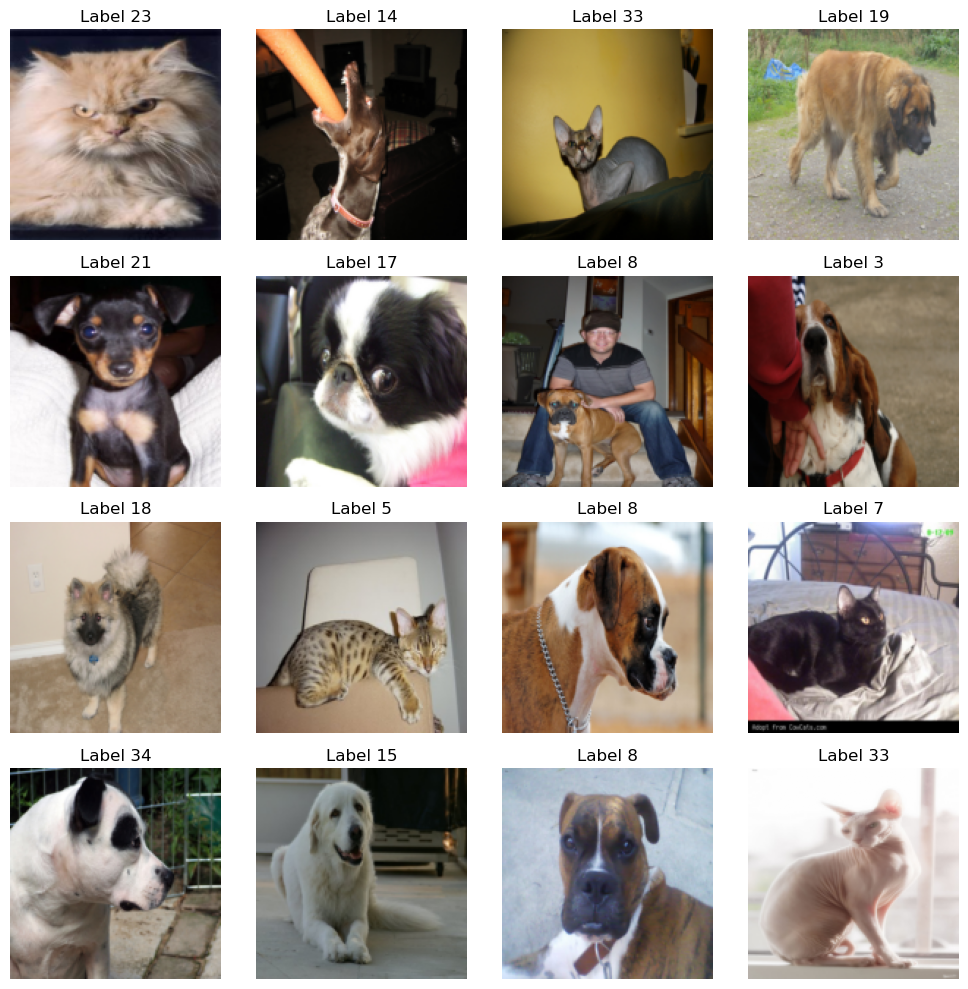

In [11]:
show_samples(samples)

In [12]:
vit = ViT(
    img_res=img_res,
    patch_res=patch_res,
    in_chans=in_chans,
    embed_dim=embed_dim,
    n_heads=n_heads,
)
res = vit(x)
res, count_parameters(vit)

(tensor([[ 0.0972,  0.1177, -0.0259,  0.1204,  0.1615, -0.0752,  0.0406, -0.1932,
           0.3367, -0.1311, -0.2278, -0.2066,  0.0909,  0.1571,  0.1698,  0.0745,
          -0.1016,  0.1797,  0.2839, -0.0948,  0.0965,  0.2184, -0.0109, -0.2099,
          -0.3549, -0.0272, -0.1755, -0.2191,  0.2491,  0.1090,  0.3094, -0.1377,
           0.2087, -0.0157,  0.1921,  0.2205, -0.0031]],
        grad_fn=<AddmmBackward0>),
 1421605)

In [13]:
summary(
    model=vit,
    input_size=(batch_size, *x.shape),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                               [256, 3, 144, 144]        [256, 37]                 --                        True
├─Sequential (model)                                    [256, 3, 144, 144]        [256, 37]                 --                        True
│    └─ViTEmbedding (0)                                 [256, 3, 144, 144]        [256, 82, 256]            20,992                    True
│    │    └─Sequential (patch_embed)                    [256, 3, 144, 144]        [256, 81, 256]            196,864                   True
│    └─TransformerEncoder (1)                           [256, 82, 256]            [256, 256]                --                        True
│    │    └─Sequential (model)                          [256, 82, 256]            [256, 256]                1,053,184                 True
│    └─MLP (2)        

In [14]:
results = []
train_loader, test_loader = make_loader(dataset, batch_size)

In [15]:
results.append({"label": "ViT"})
train(
    model=vit,
    result=results[-1],
    loss_fn=nn.CrossEntropyLoss(),
    n_epochs=n_epochs,
    train_loader=train_loader,
    test_loader=test_loader,
)

Epoch 1, Loss: 3.6385638439137002 +- 0.19471987811646055
Epoch 2, Loss: 3.6230709620144057 +- 0.12186306203219777
Epoch 3, Loss: 3.6182231226693027 +- 0.0865734196915495
Epoch 4, Loss: 3.6125730641510176 +- 0.12307983398753183
Epoch 5, Loss: 3.607381374421327 +- 0.2937627747619
Epoch 6, Loss: 3.5747713161551435 +- 0.38434674682920167
Epoch 7, Loss: 3.572660641501779 +- 0.5435226428018832
Epoch 8, Loss: 3.5279794989072757 +- 0.706651767099647
Epoch 9, Loss: 3.5121809182931547 +- 0.7150965119570548
Epoch 10, Loss: 3.504300855100155 +- 0.8231063637286081
Average time per epoch: 0:00:35.375485


{'label': 'ViT',
 'mean': [3.6385638439137002,
  3.6230709620144057,
  3.6182231226693027,
  3.6125730641510176,
  3.607381374421327,
  3.5747713161551435,
  3.572660641501779,
  3.5279794989072757,
  3.5121809182931547,
  3.504300855100155],
 'std': [0.19471987811646055,
  0.12186306203219777,
  0.0865734196915495,
  0.12307983398753183,
  0.2937627747619,
  0.38434674682920167,
  0.5435226428018832,
  0.706651767099647,
  0.7150965119570548,
  0.8231063637286081]}

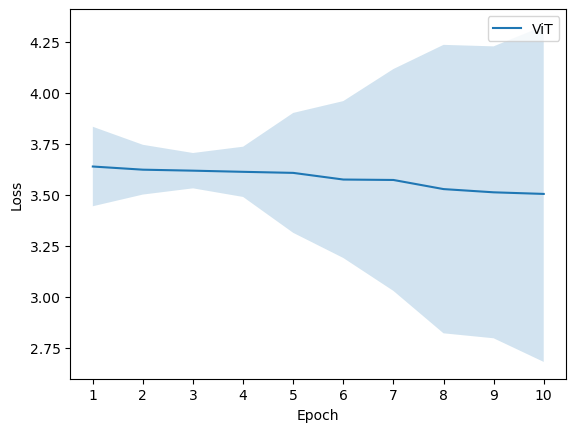

In [16]:
plot_lines(results)